In [1]:
import pandas as pd
import numpy as np
import os 
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.utils import resample

In [2]:
str_path = '../input/siim-isic-melanoma-classification'

data_dir = Path(str_path)

image_dir = os.path.join(data_dir, 'jpeg')

train_dir = os.path.join(image_dir, 'train')
test_dir = os.path.join(image_dir, 'test')

In [3]:
train_csv_file = os.path.join(data_dir, 'train.csv')
test_csv_file = os.path.join(data_dir, 'test.csv')

train_df = pd.read_csv(train_csv_file)
test_df = pd.read_csv(test_csv_file)

# Data Wrangling & Data Visualization

In [4]:
train_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null  object 
 1   patient_id                     33126 non-null  object 
 2   sex                            33061 non-null  object 
 3   age_approx                     33058 non-null  float64
 4   anatom_site_general_challenge  32599 non-null  object 
 5   diagnosis                      33126 non-null  object 
 6   benign_malignant               33126 non-null  object 
 7   target                         33126 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 2.0+ MB


In [6]:
train_df.duplicated().sum()

0

In [7]:
train_df_copy = train_df.copy()

In [8]:
train_df_copy.isnull().sum()

image_name                         0
patient_id                         0
sex                               65
age_approx                        68
anatom_site_general_challenge    527
diagnosis                          0
benign_malignant                   0
target                             0
dtype: int64

In [9]:
rows_to_remove = train_df_copy[train_df_copy['anatom_site_general_challenge'].isnull()].index

train_df_copy.drop(rows_to_remove, inplace=True)

In [10]:
rows_to_remove = train_df_copy[train_df_copy['sex'].isnull()].index

train_df_copy.drop(rows_to_remove, inplace=True)

In [11]:
rows_to_remove = train_df_copy[train_df_copy['age_approx'].isnull()].index

train_df_copy.drop(rows_to_remove, inplace=True)

In [12]:
train_df_copy.isnull().sum()

image_name                       0
patient_id                       0
sex                              0
age_approx                       0
anatom_site_general_challenge    0
diagnosis                        0
benign_malignant                 0
target                           0
dtype: int64

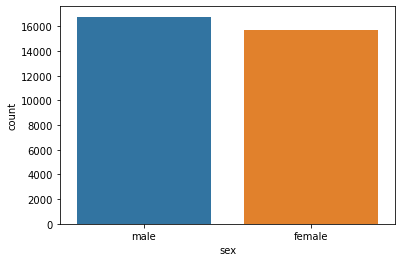

In [13]:
sns.countplot(x='sex', data=train_df_copy)

plt.show()

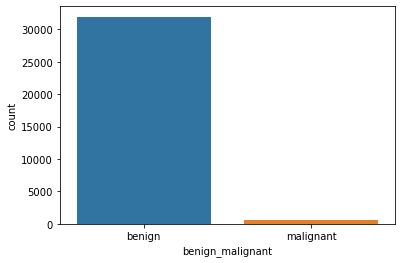

In [14]:
sns.countplot(x='benign_malignant', data=train_df_copy)

plt.show()

# Splitting Data

In [15]:
train_df_copy.query('target == 0').shape[0], train_df_copy.query('target == 1').shape[0]

(31956, 575)

In [16]:
malignant_cases = train_df_copy.query('target == 1')
benign_cases = train_df_copy.query('target == 0')

benign_size = benign_cases.shape[0]
malignant_size = malignant_cases.shape[0]

In [17]:
total_size = train_df_copy.shape[0]

train_size = int(np.rint(total_size * 0.8))
valid_size = total_size - train_size

malignant_train_size = int(np.rint(malignant_size * 0.8))

benign_train_size = int(np.rint(benign_size * 0.8))

In [18]:
malignant_cases = malignant_cases.sample(frac=1).reset_index(drop=True)
malignant_train_cases = malignant_cases.sample(malignant_train_size)
malignant_valid_cases = malignant_cases[~malignant_cases.image_name.isin(malignant_train_cases.image_name)]

malignant_train_cases.shape, malignant_valid_cases.shape

((460, 8), (115, 8))

In [19]:
benign_cases = benign_cases.sample(frac=1).reset_index(drop=True)
benign_train_cases = benign_cases.sample(benign_train_size)
benign_valid_cases = benign_cases[~benign_cases.image_name.isin(benign_train_cases.image_name)]

benign_train_cases.shape, benign_valid_cases.shape

((25565, 8), (6391, 8))

In [20]:
df_minority_upsampled = resample(malignant_train_cases, 
                         replace=True,       # sample with replacement
                         n_samples=benign_train_size,    # to match majority class
                         random_state=42)

In [21]:
df_train = pd.concat([benign_train_cases, df_minority_upsampled])

df_train = df_train.sample(frac=1).reset_index(drop=True)

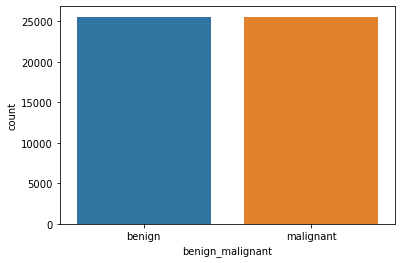

In [22]:
sns.countplot(x='benign_malignant', data=df_train)

plt.show()

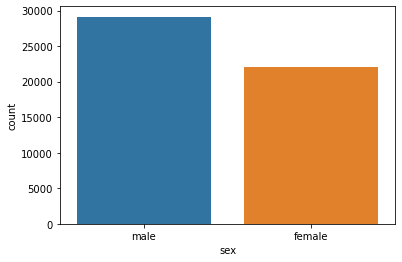

In [23]:
sns.countplot(x='sex', data=df_train)

plt.show()

In [24]:
df_valid = pd.concat([benign_valid_cases, malignant_valid_cases])

df_valid = df_valid.sample(frac=1).reset_index(drop=True)

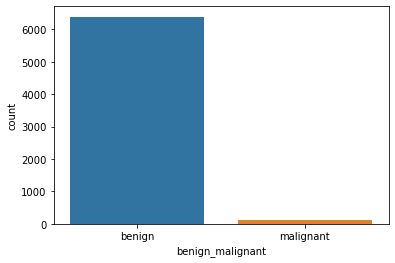

In [25]:
sns.countplot(x='benign_malignant', data=df_valid)

plt.show()

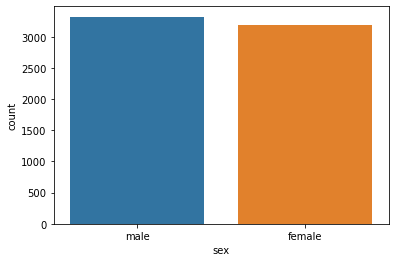

In [26]:
sns.countplot(x='sex', data=df_valid)

plt.show()

In [27]:
training_data_filepath = os.path.join('.', "train_data.csv")
df_train.to_csv (training_data_filepath, index = True, header = True)

In [28]:
validation_data_filepath = os.path.join('.', "valid_data.csv")
df_valid.to_csv (validation_data_filepath, index = True, header = True)